# Hardware execution options

In this notebook we illustrate how to use various settings when executing QAOA on hardware. We consider fractional gates to implement $R_Z(\theta)$ gates for any $\theta$ and $R_{ZZ}(\theta)$ gates with $\theta\in[0,\pi/2]$. Furthermore, we will also study the impact of the repetition delay on speed and quality. We will do this with a maximum cut problem on a heavy-hex hardware native weighted graph. The circuit is a depth-one QAOA. In addition to this, we will also show how to create a good edge coloring of the backend coupling map to apply gates in a compact fashion.

In [1]:
from copy import deepcopy
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import SwapStrategy

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2

from qaoa_training_pipeline.training import DepthOneScanTrainer
from qaoa_training_pipeline.evaluation import EfficientDepthOneEvaluator
from qaoa_training_pipeline.visualization.plotting import plot_cdf
from qaoa_training_pipeline.utils.graph_utils import solve_max_cut, graph_to_operator

from qopt_best_practices.utils import build_max_cut_paulis
from qopt_best_practices.sat_mapping import SATMapper
from qopt_best_practices.transpilation import qaoa_swap_strategy_pm, remove_instruction_from_target
from qopt_best_practices.cost_function.cost_utils import counts_to_maxcut_cost

## 1. Load a graph

The graph is stored in json format and has weighted edges. Here, we also compute the minimum and maximum cut values. We will transpile the circuit using the swap strategy methodology. Here, since the graph is hardware native we only need an empty swap strategy. To ensure that the gates are applied as compactly as possible we need an **edge coloring** of the coupling map of the device. This edge coloring is easily found by performing a node coloring of the *line graph* ${\rm L}(C)$ of the coupling map $C$. By definition, each vertex of $L(C)$ corresponds to an edge of $C$ and each edge of $L(C)$ maps to a node of $C$. Therefore, a node coloring of $L(C)$ corresponds to the desired edge coloring of $C$.

In [2]:
with open("data/graph_heavy_hex_42q_0s.json", "r") as fin:
    data = json.load(fin)

sat_graph = nx.Graph()

for edge in data["edge list"]:
    sat_graph.add_edge(edge["nodes"][0], edge["nodes"][1], weight=edge["weight"])

cmap = CouplingMap(sat_graph.edges())
cmap.make_symmetric()

swap_strat = SwapStrategy(cmap, ())
edge_coloring = nx.greedy_color(nx.line_graph(sat_graph), strategy="saturation_largest_first")
edge_coloring.update({(k[1], k[0]): v for k, v in edge_coloring.items()})

cost_operator = graph_to_operator(sat_graph, pre_factor=-0.5)
max_cut, min_cut, _ = solve_max_cut(cost_operator)
print(f"Maximum cut {max_cut}, on {sat_graph.order()} qubits")

Maximum cut 21.38955085456199, on 42 qubits


Note that for a heavy-hex graph, the optimal number of edge colors should be three. More edge colors than three are sub-optimal. Depending on the strategy given to `greedy_color` we may get different results.

Text(0.5, 1.0, 'Number of colors 3')

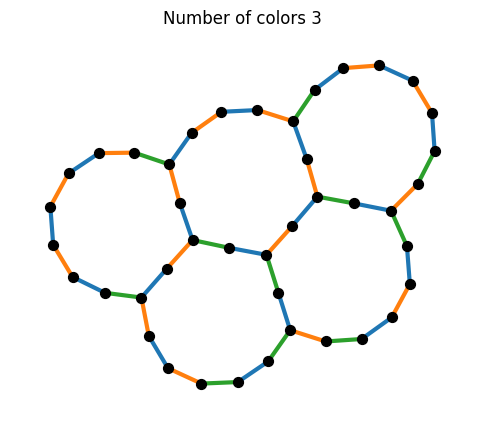

In [3]:
fig, axs = plt.subplots(1, 1, figsize=(6, 5))
colors = {idx: f"C{idx}" for idx in edge_coloring.values()}
graph_ = nx.Graph()
graph_.add_edges_from(cmap.get_edges())
nx.draw_kamada_kawai(graph_, edge_color=[colors[edge_coloring[e]] for e in  graph_.edges()], ax=axs, node_size=50, width=3, node_color="k")
axs.set_title(f"Number of colors {len(set(edge_coloring.values()))}")

## 2. QAOA parameter finding

Now, we find the QAOA parameters for depth-one. We do this with the `qaoa-training-pipeline` and use a simple parameter scan with an efficient evaluation of the depth-one energy.

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='Gamma', ylabel='Beta'>)

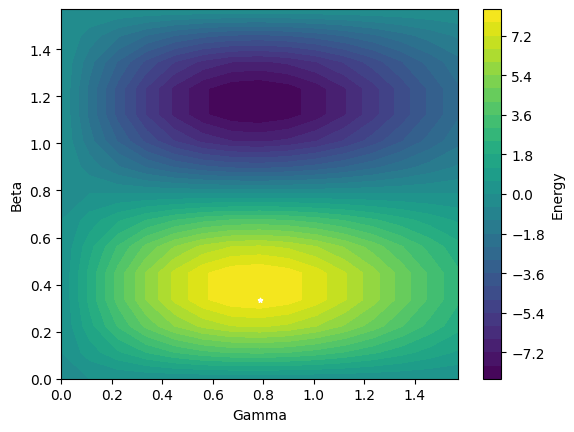

In [4]:
trainer = DepthOneScanTrainer(EfficientDepthOneEvaluator())
params_res = trainer.train(cost_operator, parameter_ranges=((0, np.pi/2), (0, np.pi/2)))
trainer.plot()

## 3. Exeuction with and without fractional gates

First, we investigate the effect of fractional gates on the quality of the samples produced by the backend.

### 3.1 Circuit preparation

Now, we prepare the circuits to evaluate on the backend. We will prepare three different circuits.

1. The circuit transpiled to the standard basis gates in which all angles are encoded into virtual $R_Z(\theta)$ gates.
2. The circuit transpiled to the fractional basis gate set in which $R_{ZZ}(\theta)$ and $R_X(\theta)$ are both available.
3. The circuit transpiled to the fractional basis gate set in which only $R_X(\theta)$ is available. Here, the two-qubit gates are implemented with $CZ$ gates.

The following transpiler passes serve to prepare the QAOA circuit in a compact form.

In [5]:
cost_layer = QAOAAnsatz(
    cost_operator,
    reps=1,
    initial_state=QuantumCircuit(sat_graph.order()),
    mixer_operator=QuantumCircuit(sat_graph.order()),
    name="QAOA cost block",
)

In [6]:
pm_config = {
    "swap_strategy": swap_strat,
    "edge_coloring": edge_coloring,
    "basis_gates": ["x", "sx", "rz", "rzz", "cx"]
}
qaoa_pm = qaoa_swap_strategy_pm(pm_config)

In [7]:
qaoa_circ = qaoa_pm.run(cost_layer)
qaoa_circ.assign_parameters(params_res["optimized_params"], inplace=True)

In the cell below we check that two-qubit gate depth of the QAOA circuit. This should be the same as the number of colors in the edge coloring.

In [8]:
qaoa_circ.depth(lambda inst: inst.name == "rzz")

3

Now, we prepare two circuits. One with $R_{ZZ}$ gates and one with CZ gates. Note, that if the circuit had SWAP gates we may need to perform an extra transpilation step through CX gates due to this issue: https://github.com/Qiskit/qiskit/pull/13419 when preparing the $R_{ZZ}$-based circuit.

In [9]:
qaoa_circ_rzz = transpile(qaoa_circ, basis_gates=["sx", "rx", "rzz", "x", "measure", "rz"])
qaoa_circ_cz = transpile(qaoa_circ_rzz, basis_gates=["sx", "rx", "cz", "x", "measure", "rz"])

Now, we setup our provider and initialize backens with and without fractional gates.

In [10]:
from qiskit import __version__ as qiskit_version
from qiskit_ibm_runtime import __version__ as runtime_version

print(f"{qiskit_version=} {runtime_version=}")

qiskit_version='1.4.3' runtime_version='0.40.1'


In [12]:
service = QiskitRuntimeService(instance="<your instance>")

In [27]:
backend_name = "ibm_fez"

backend_c = service.backend(backend_name)  # w/o fractional gates
backend_f = service.backend(backend_name, use_fractional_gates=True)  # w/ fractional gates
target_f2 = remove_instruction_from_target(backend_f.target, "rzz")
print(f"Backend: {backend_name}")
print(f"No fractional gates: {list(backend_c.target.operation_names)}")
print(f"With fractional Rx and Rzz gates: {list(backend_f.target.operation_names)}")
print(f"With fractional Rx gates only: {list(target_f2.operation_names)}")

Backend: ibm_fez
No fractional gates: ['id', 'reset', 'measure', 'rz', 'cz', 'delay', 'sx', 'x']
With fractional Rx and Rzz gates: ['rx', 'sx', 'x', 'id', 'rzz', 'reset', 'measure', 'rz', 'cz', 'delay']
With fractional Rx gates only: ['rx', 'sx', 'x', 'id', 'reset', 'measure', 'rz', 'cz', 'delay']


Now we prepare the three different circuits in the backend's instruction set architecture. Note, that to create the circuit with $R_X$ gates but without $R_{ZZ}$ gates we pass the basis gate set to the transpiler. This approach may be brittle and a better one could be based on the package https://github.com/Qiskit/qiskit-basis-constructor. However, this is out of scope for this how-to. In any case, we will carefully check that the output of the transpiler is the anticipated one.

In [20]:
isa_circ_c = transpile(qaoa_circ_cz, backend_c)
isa_circ_f = transpile(qaoa_circ_rzz, backend_f)
isa_circ_f2 = transpile(qaoa_circ_rzz, target=target_f2)

Below, we print out the circuits. We observe that with fractional gates the circuit duration is shorter. We also check that the `isa_circ_f2` circuit does not have any fractional $R_{ZZ}$ gates.

Estimate duration without fractional gates 2.30 us
Gate counts OrderedDict([('rz', 270), ('sx', 264), ('cz', 92), ('measure', 42), ('x', 32)])


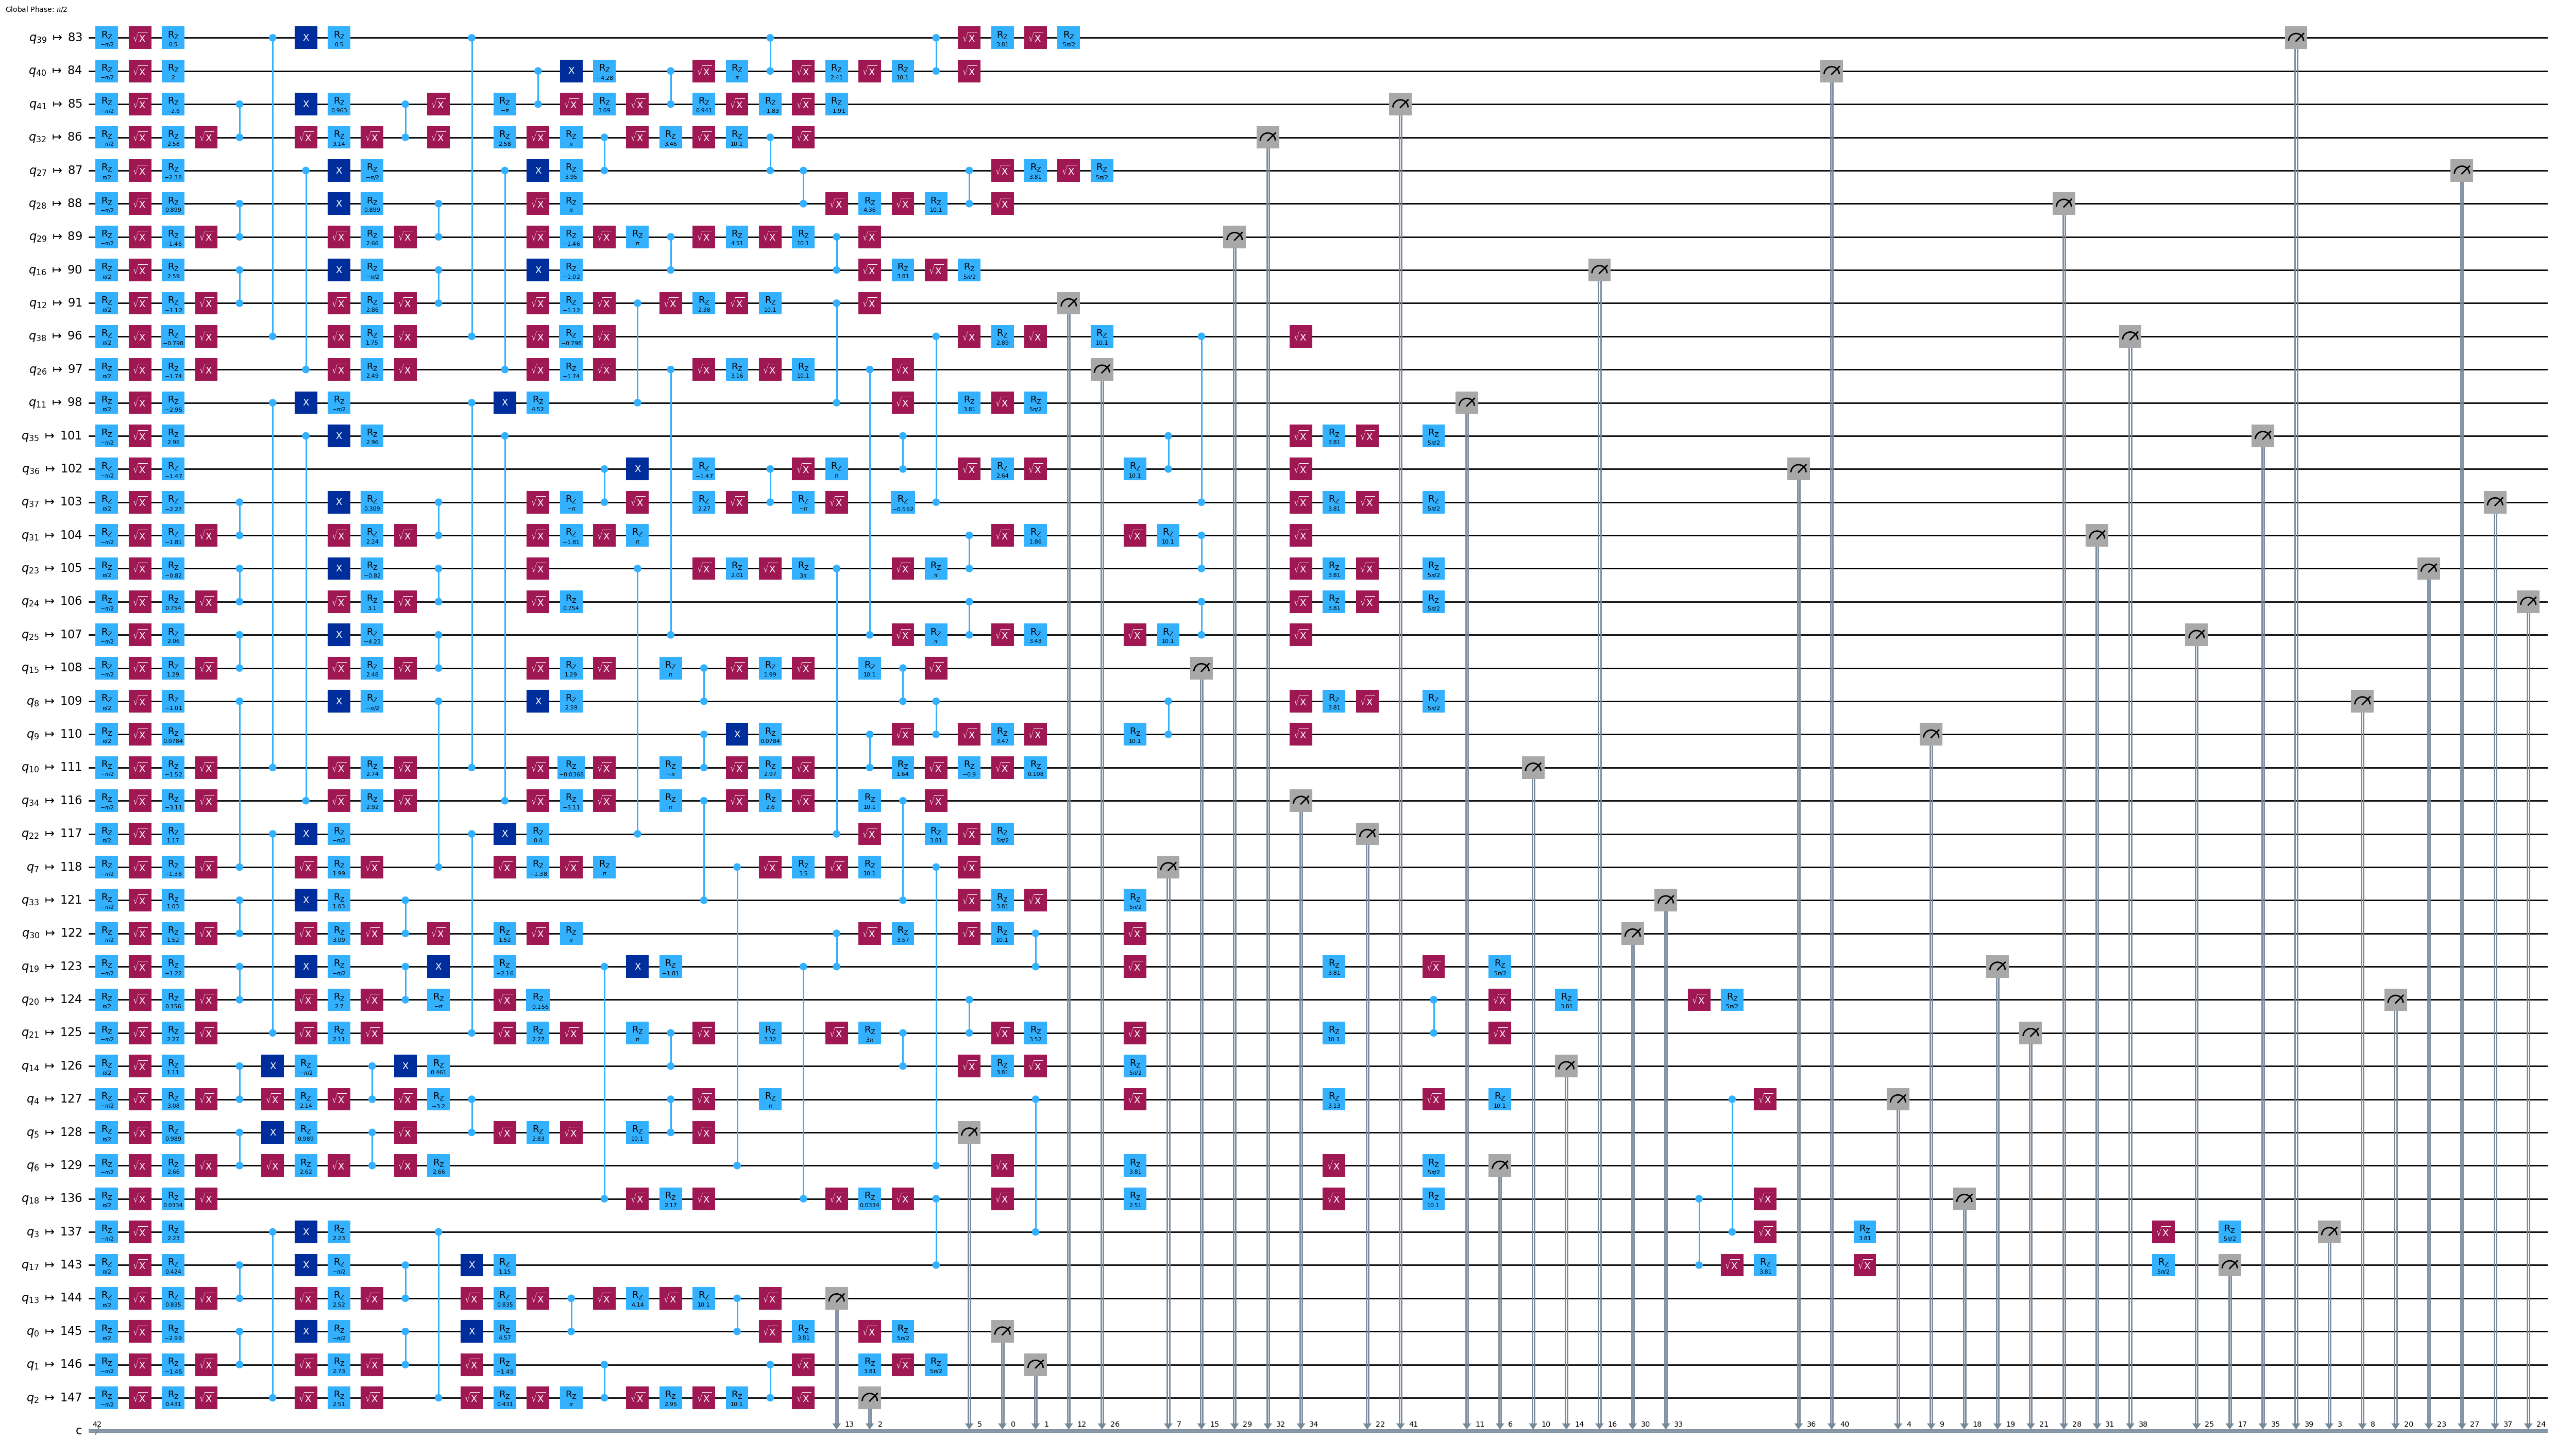

In [21]:
print(f"Estimate duration without fractional gates {isa_circ_c.estimate_duration(backend_c.target) * 1e6:.2f} us")
print("Gate counts", isa_circ_c.count_ops())
isa_circ_c.metadata["Note"] = "Transpiled with non-fractional basis gates."
isa_circ_c.draw("mpl", fold=False, idle_wires=False)

Estimate duration with fractional Rx and Rzz gates 1.91 us
Gate counts OrderedDict([('rz', 84), ('rx', 55), ('rzz', 46), ('measure', 42), ('sx', 29), ('x', 25)])


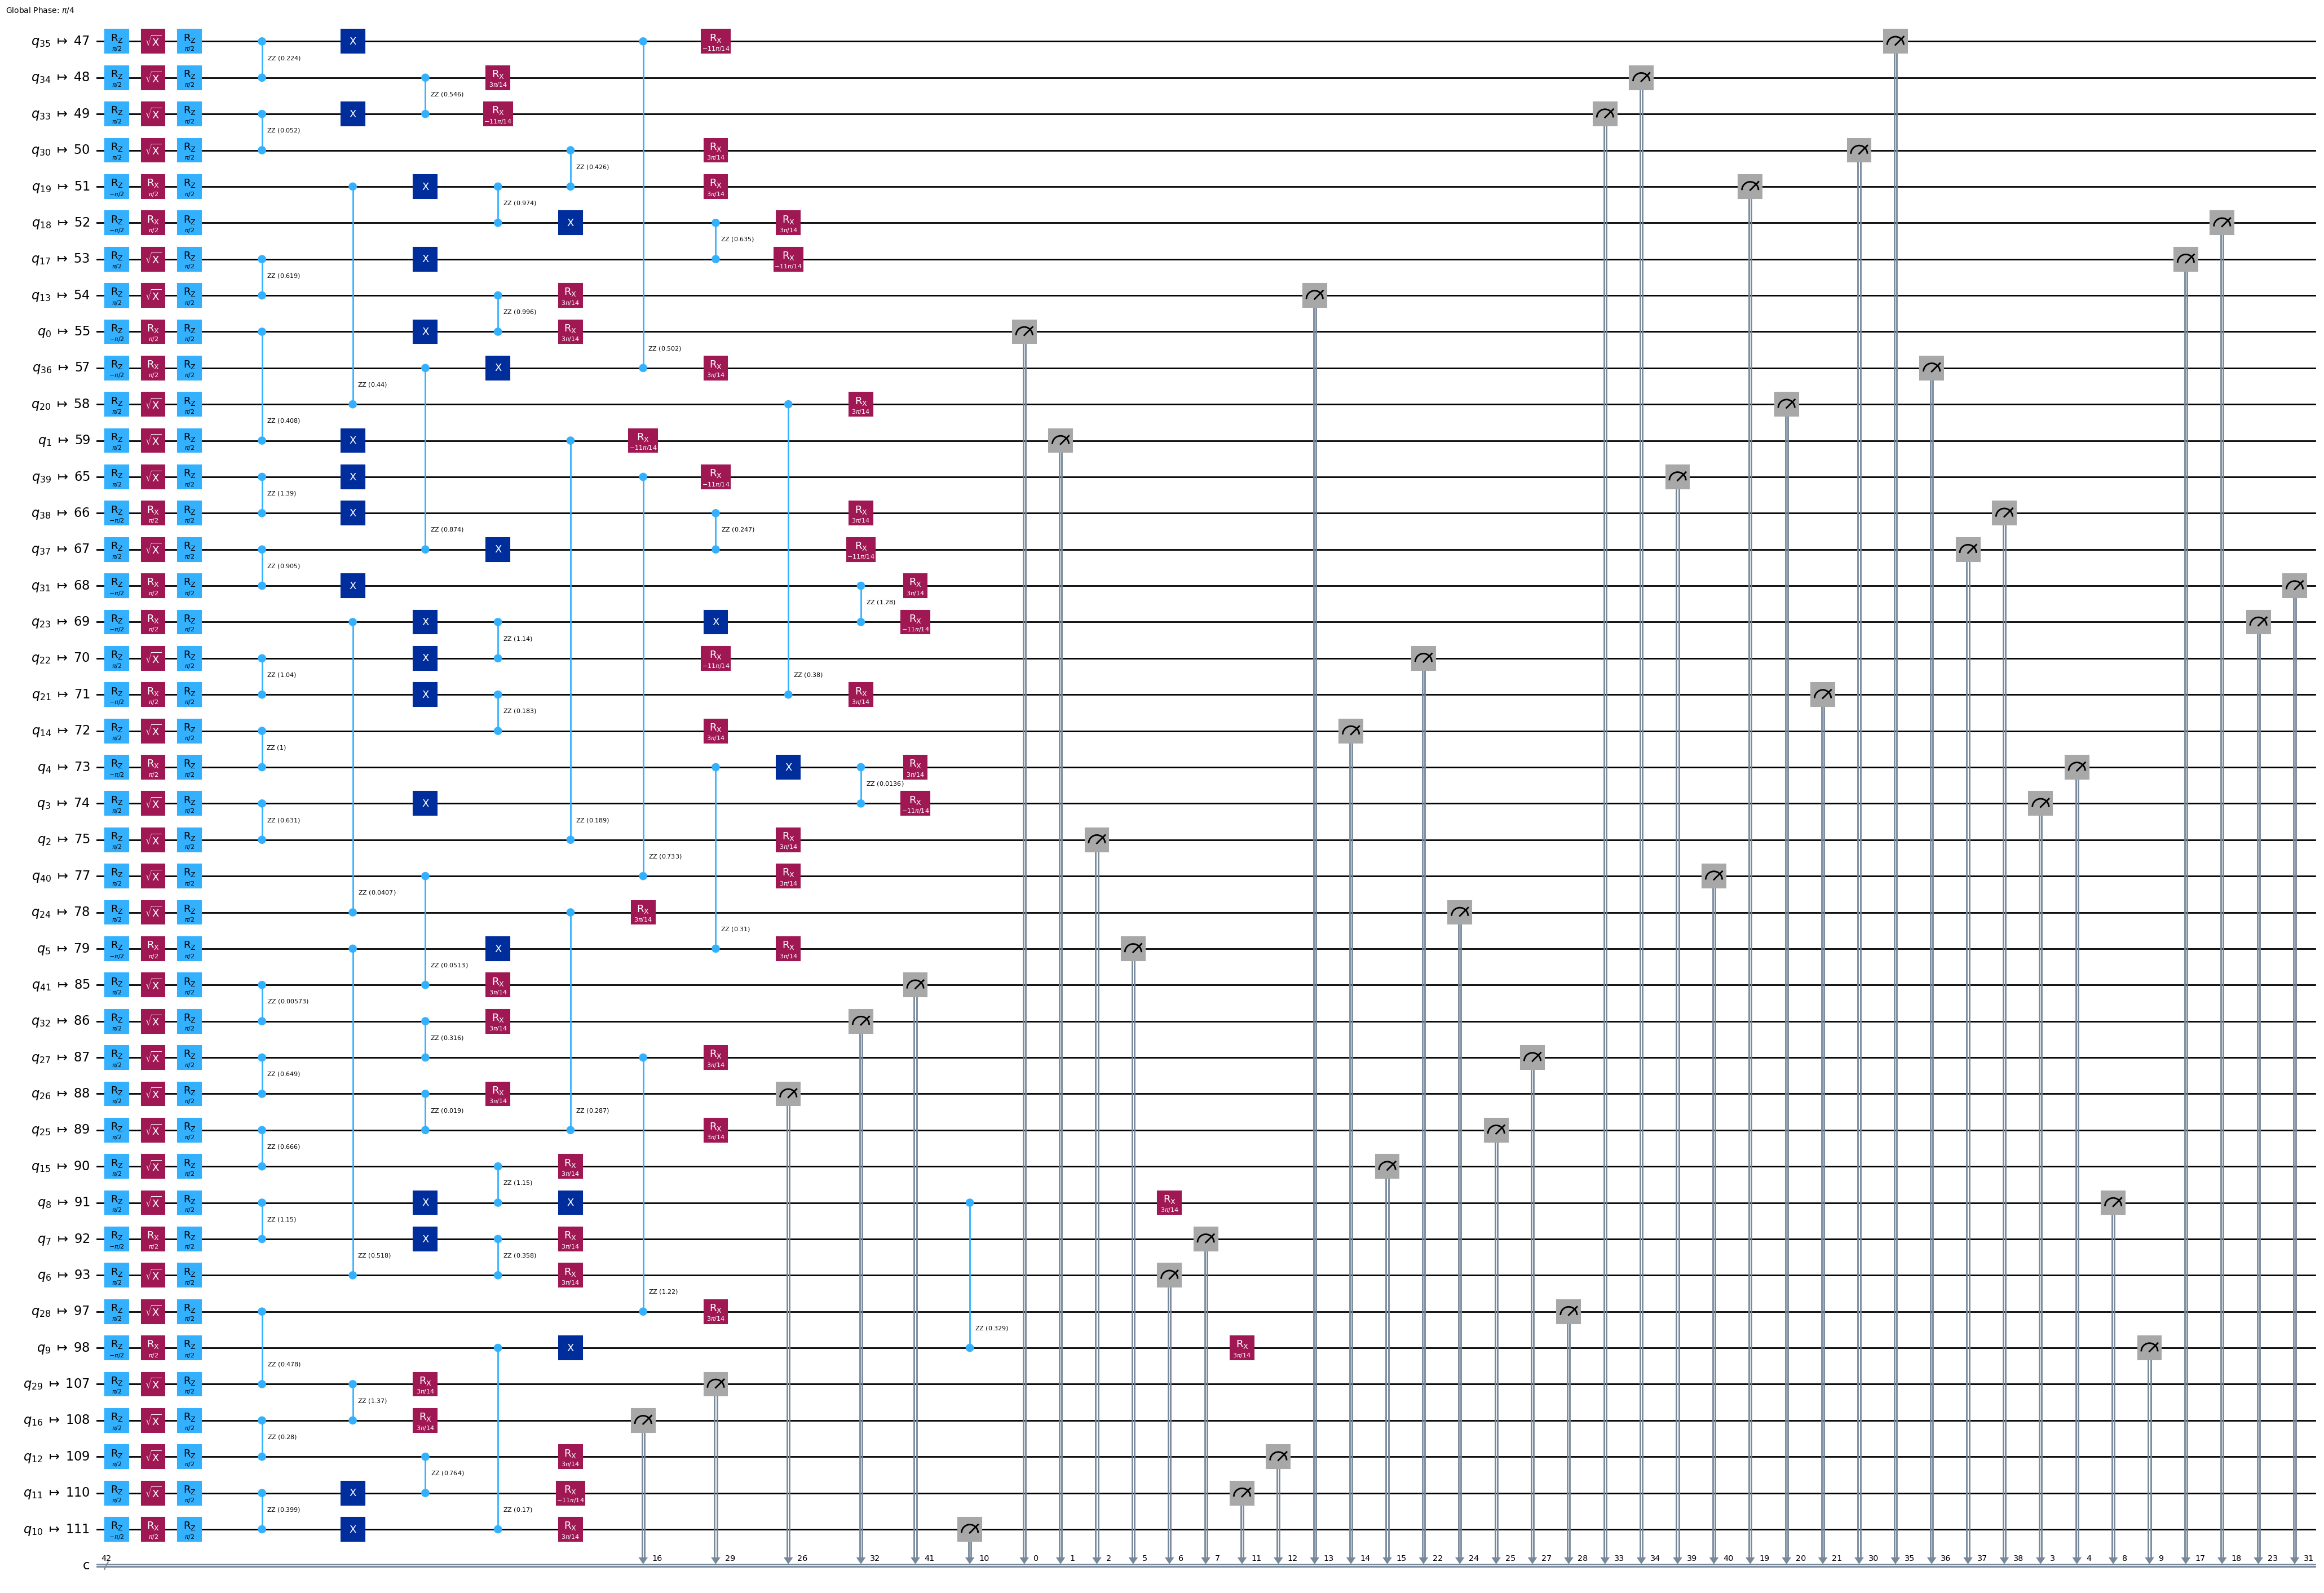

In [22]:
# This circuit has an issue. There are too many Rzz gates.
print(f"Estimate duration with fractional Rx and Rzz gates {isa_circ_f.estimate_duration(backend_f.target) * 1e6:.2f} us")
print("Gate counts", isa_circ_f.count_ops())
isa_circ_f.metadata["Note"] = "Transpiled with rzz and rx fractional gates."
isa_circ_f.draw("mpl", fold=False, idle_wires=False)

Estimate duration with fractional Rx gates only 2.18 us
Gate counts OrderedDict([('rx', 177), ('rz', 146), ('cz', 92), ('measure', 42), ('sx', 9)])


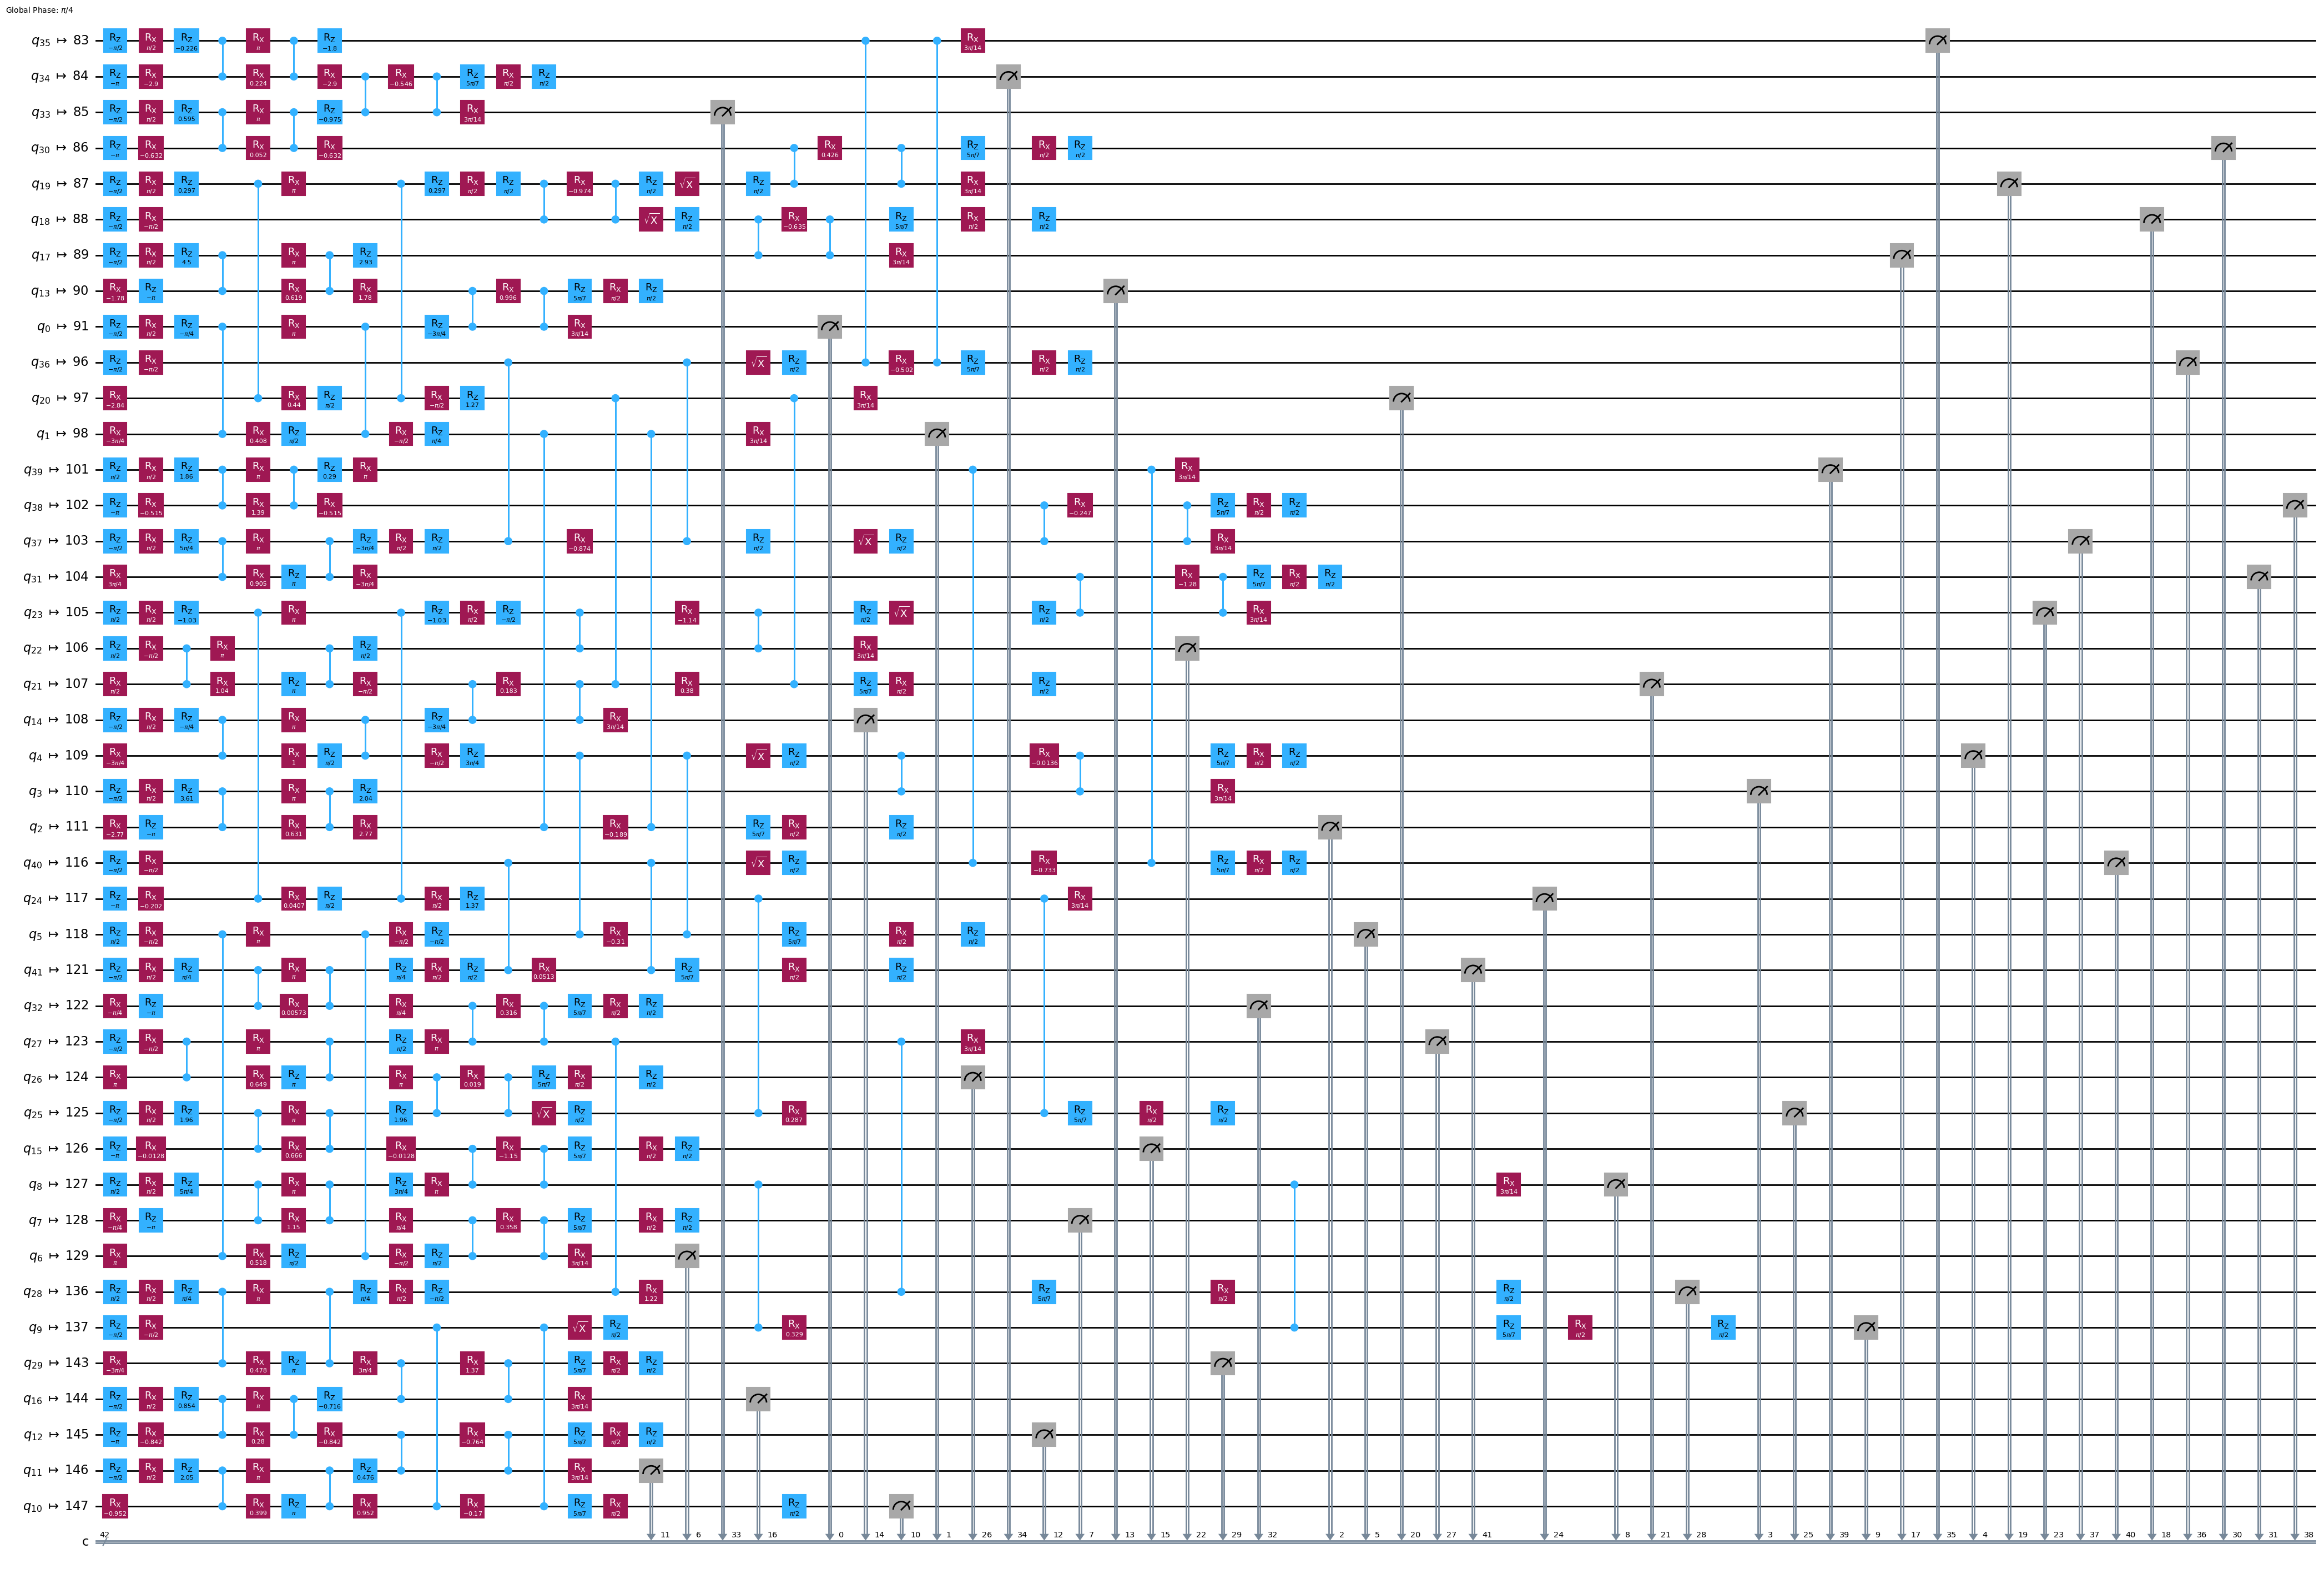

In [23]:
print(f"Estimate duration with fractional Rx gates only {isa_circ_f2.estimate_duration(backend_f.target) * 1e6:.2f} us")
print("Gate counts", isa_circ_f2.count_ops())
isa_circ_f2.metadata["Note"] = "Transpiled with rx fractional gates only."
isa_circ_f2.draw("mpl", fold=False, idle_wires=False)

### 3.2 Hardware execution and result analysis

We now execute the circuits and plot the cumulative distribution function of the resulting samples.

In [81]:
run_circuits = True

if run_circuits:
    sampler_c = SamplerV2(mode=backend_c)
    sampler_f = SamplerV2(mode=backend_f)
    
    job_c = sampler_c.run([isa_circ_c])
    job_f = sampler_f.run([isa_circ_f, isa_circ_f2])
    print(f"Conventional job {job_c.job_id()}\nFractional gates job {job_f.job_id()}")
else:
    job_c = service.job("d1ck5b47tq0c73ddjm5g")
    job_f = service.job("d1ck5bc7tq0c73ddjm60")

Conventional job d1ck5b47tq0c73ddjm5g
Fractional gates job d1ck5bc7tq0c73ddjm60


In [88]:
result_c = job_c.result()
result_f = job_f.result()

In [89]:
mc_cost_c = counts_to_maxcut_cost(sat_graph, result_c[0].data.c.get_counts())
mc_cost_f = counts_to_maxcut_cost(sat_graph, result_f[0].data.c.get_counts())
mc_cost_f2 = counts_to_maxcut_cost(sat_graph, result_f[1].data.c.get_counts())

Below, we observe that the fractional gates (dotted dashed orange curve) perform worse than the conventional `CZ` gates (solid blue curve) on `ibm_fez` because the orange CDF is shifted towards lower objective values. The $R_{X}$ fractional gates with CZ gates (dotted dashed green curve) perform about as well as the standard basis gate set. However, there can be some variability between runs. From these results we conclude that fractional CZ gates tend not to perform as well as `CZ` gates. Note that this conclusion may depend on the backend, and the structure and depth of the QAOA circuit. Therefore, if you are considering executing QAOA on hardware it may still make sense to compare fractional gates to non-fractional gates.

Text(0, 0.5, 'CDF')

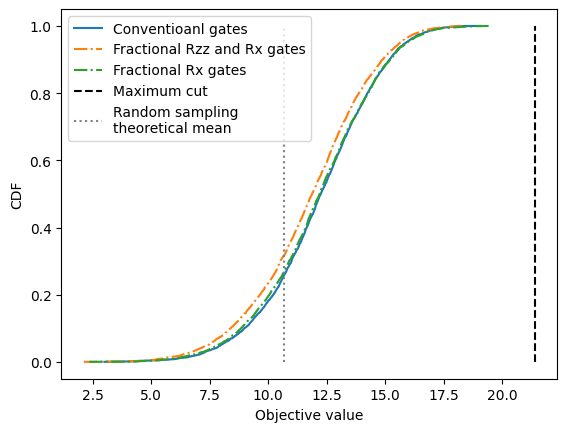

In [90]:
fig, axs = plt.subplots(1, 1)
plot_cdf(mc_cost_c, fig=fig, axis=axs, label="Conventioanl gates")
plot_cdf(mc_cost_f, fig=fig, axis=axs, label="Fractional Rzz and Rx gates", ls="-.")
if mc_cost_f2:
    plot_cdf(mc_cost_f2, fig=fig, axis=axs, label="Fractional Rx gates", ls="-.")
axs.vlines(max_cut, 0, 1, ls="--", color="k", label="Maximum cut")
axs.vlines(max_cut/2, 0, 1, ls=":", color="grey", label="Random sampling\ntheoretical mean")
axs.legend()
axs.set_xlabel("Objective value")
axs.set_ylabel("CDF")

## 4. execution speed

Here, we use the circuit from the previous study with $R_{X}$ and CZ gates and investigate if we can generate samples faster by changing the `rep_delay` of the sampler. The `rep_delay` is a delay between circuit executions. As we will see, changing this value can lead to a faster generation of samples at the risk of a deterioration in sample quality. By default the `rep_delay` of the backend is

In [181]:
print(f"Default repetition delay: {backend_f.default_rep_delay*1e6:.0f}us")

Default repetition delay: 250us


In the following cells we will scan the `rep_delay` from the minimum to the maximum and study the quality of the cumulative distribution function of depth-one QAOA. Note that a `rep_delay` of zero is typically too small and may result in errors.

In [142]:
max_rep = backend_f.rep_delay_range[1]
min_rep = backend_f.rep_delay_range[0]

job_ids = {"Description": "The key is the rep_delay and the value is the job_id."}
jobs = {"Description": "The key is the rep_delay and the value is the job."}

for delay in np.linspace(min_rep, max_rep, 6):
    sampler = SamplerV2(mode=backend_f, options={"execution": {"rep_delay": delay}})
    job_f = sampler.run([isa_circ_f2], shots=2**14)
    jobs[delay] = job_f
    job_ids[delay] = job_f.job_id()
    print(f"Rep delay {delay} done in job {job_f.job_id()}")

Rep delay 0.0 done in job d1cmjo7d1s7s73ah8bl0
Rep delay 0.0001 done in job d1cmjoc7tq0c73ddm42g
Rep delay 0.0002 done in job d1cmjoc7tq0c73ddm430
Rep delay 0.00030000000000000003 done in job d1cmjomc0o9c73apver0
Rep delay 0.0004 done in job d1cmjos7tq0c73ddm440
Rep delay 0.0005 done in job d1cmjos7tq0c73ddm44g


We observe a strong impact of the `rep_delay` on the time it takes to execute the QAOA circuit on the QPU.

In [148]:
mc_costs, usage = {}, {}

for delay, job in jobs.items():
    if isinstance(job, str):
        continue

    try:
        mc_costs[delay] = counts_to_maxcut_cost(sat_graph, job.result()[0].data.c.get_counts())
        usage[delay] = job.usage()
        print(f"The delay of {delay*1e6:.0f} us required {job.usage()} QPU seconds.")
    except:
        pass

The delay of 100 us required 3 QPU seconds.
The delay of 200 us required 5 QPU seconds.
The delay of 300 us required 7 QPU seconds.
The delay of 400 us required 8 QPU seconds.
The delay of 500 us required 10 QPU seconds.


Below, we observe that the repetition delay does not significantly impact the cumulative distribution. There is a small improvement of the longest repetition delay over the shorter ones.

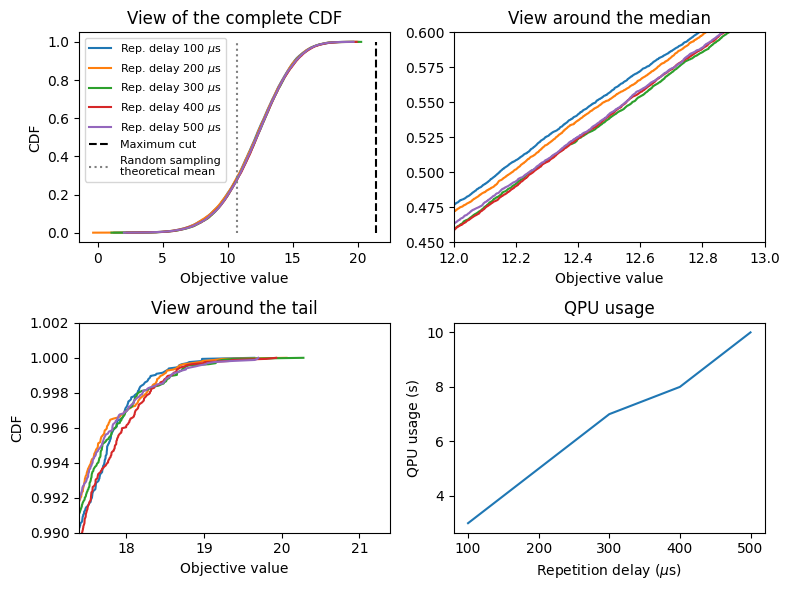

In [161]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs = axs.flatten()

for delay, mc_cost in mc_costs.items():
    plot_cdf(mc_cost, fig=fig, axis=axs[0], label=f"Rep. delay {1e6*delay:.0f} $\mu$s")
    plot_cdf(mc_cost, fig=fig, axis=axs[1], label=f"Rep. delay {1e6*delay:.0f} $\mu$s")
    plot_cdf(mc_cost, fig=fig, axis=axs[2], label=f"Rep. delay {1e6*delay:.0f} $\mu$s")

delays = sorted(mc_costs.keys())
axs[3].plot([val*1e6 for val in delays], [usage[delay] for delay in delays])

axs[0].vlines(max_cut, 0, 1, ls="--", color="k", label="Maximum cut")
axs[0].vlines(max_cut/2, 0, 1, ls=":", color="grey", label="Random sampling\ntheoretical mean")
axs[0].legend(fontsize=8)
axs[1].set_xlim([12, 13])
axs[1].set_ylim([0.45, 0.6])
axs[2].set_xlim([max_cut - 4, max_cut])
axs[2].set_ylim([0.99, 1.002])
axs[0].set_title("View of the complete CDF")
axs[1].set_title("View around the median")
axs[2].set_title("View around the tail")
axs[3].set_title("QPU usage")
axs[0].set_ylabel("CDF")
axs[2].set_ylabel("CDF")
for ax in axs[0:3]:
    ax.set_xlabel("Objective value")

axs[3].set_xlabel("Repetition delay ($\mu$s)")
axs[3].set_ylabel("QPU usage (s)")

fig.tight_layout()

As we can see from the plots above and the medians below there is a small degradation in the median approxmation ratio of about 0.2-0.3% when using a shorter `rep_delay` than the default of the backend. However, the is a significant increase in circuit execution speed. Therefore, we can lower the `rep_delay` from its default value to generate samples much faster without significantly compromising on quality.

In [178]:
print("Delay (us)    Median approximation ratio")
for delay, mc_cost in mc_costs.items():
    approx = (np.median(list(mc_cost.keys())) - min_cut) / (max_cut - min_cut)
    print(f"{delay*1e6:.0f}           {approx*100:.1f}%.")

Delay (us)    Median approximation ratio
100           72.4%.
200           72.6%.
300           72.7%.
400           72.8%.
500           72.7%.
